# Facebook Messages Parser and Analyzer

<b> Current Features for each Chat: </b>

<ul> 
<li> Create bar charts that contain the following information for each person
<ul> 
    <li> Average response time in minutes </li> 
    <li> Number of conversations initiated </li> 
    <li> Character count on average</li>
</ul>
</ul>

In [77]:
import pylab as pl
import numpy as np
import time
import os
from datetime import datetime, date, timedelta
from collections import Counter

%matplotlib inline

from lxml import etree
parser = etree.XMLParser(recover=True)

# number of conversations/html files you'd like to analyze
NUMBER_TO_ANALYZE = 100

# location of the html files
DIRECTORY = 'messages/'

## Reading in Data 

In [78]:
# Helper function to filter out tags of a certain class
def filter_class(root, tag, class_):
    results = [] 
    for div in root.findall(tag):
        if 'class' in div.attrib and div.attrib['class'] == class_:
            results.append(div)
    if len(results) == 1: 
        return results[0]
    else: 
        return results

# translates a FB message time into a dateTime object
def getTime(string_time):
    # print string_time
    return datetime.fromtimestamp(time.mktime(time.strptime(string_time[:-3], "%A, %B %d, %Y at %I:%M%p ")))

# returns the difference in mins between two string times 
def minutes_difference(time1, time2):
    return (getTime(time1) - getTime(time2)).seconds / 60.0

In [79]:
chats = []

for i in range(NUMBER_TO_ANALYZE):
    tree = etree.parse(DIRECTORY + str(i) + '.html',parser=parser)
    root = tree.getroot()
    body = root.find('body')
    divs = body.findall('div')
    results = []
    for div in divs:
        if 'class' in div.attrib and div.attrib['class'] == 'thread':
            chats.append(div)

## Extracting Data

In [80]:
# counter to enumerate all chats
index = 0
all_names = []

# main function
def getChatInfo(content, threshold, up_limit = 5 * 365, low_limit = 0):
    global index
   
    previous_user = ''
    cur_user = ''
    names =  []
    
    times = {}
    previous_time = None 
    first = True 
    starts = Counter()
    char_counts = {}
    
    skip_message = False

    # iterate over elements within contents (they flip between message headers and message contents)
    for message in content:
        # if the element is a message header (which contains name of person and time)
        if message.tag == 'div': 

            user = message.find('div').find('span').text
            cur_user = user
            message_time = filter_class(message.find('div'), 'span', 'meta').text
            days_since_message = (datetime.now() - getTime(message_time)).days
            
            if user not in names:
                names.append(user)
            
            # don't look at messages that are super old (or in the future...)
            if days_since_message > up_limit or days_since_message < low_limit: 
                skip_message = True
                continue
            
            # need this to initialize stuff
            if first:
                first = False
                starts[user] += 1
                previous_time = message_time 
                previous_user = user
                continue
            # someone responded!
            elif previous_user != user:         
                diff = minutes_difference(previous_time, message_time)
                previous_time = message_time
                # probably continuing the conversation
                if diff < threshold:
                    if user in times: 
                        times[user].append(diff)
                    else: 
                        times[user] = [diff]
                # we'll assume someone initiated a new conversation here otherwise (emphasis on assume)
                else:
                    starts[user] += 1
                previous_user = user
        # if the element is the message content, calculate character counts
        elif not skip_message and message.tag == 'p' and cur_user != None:
            if message.text == None:
                continue
            
            msg_len = len(message.text)
            if cur_user in char_counts:
                char_counts[cur_user].append(msg_len)
            else:
                char_counts[cur_user] = [msg_len]
            
        skip_message = False
    
    no_name = False
    
    for name in names:
        if name == None:
            no_name = True
           
    if not no_name:
        print ("%3s" % str(index)) + ' - ' + str(len(content)/2) + ' messages - ' + ', '.join(names)
    
    index += 1
    all_names.append(names)
    
    return times, starts, char_counts

# calculates the total character count and average response time 
def modify_dicts(t, s, c):  
    for item in t:
        t[item] = np.mean(np.array(t[item]))
    for item in c:
        c[item] = np.mean(np.array(c[item]))
    return t,s,c

In [81]:
# wraps together getChatInfo and modify_dicts

# change the 180 below to modify the upper bound on a message response time for initiating conversation
def compile_stats(chat_num, up_limit = 5*365, low_limit = 0):
    t, s, c = getChatInfo(chats[chat_num], 180, up_limit = up_limit, low_limit = low_limit)
    return modify_dicts(t,s,c)

### Here is your Chat Number Legend:

In [82]:
t_global = []
s_global = []
c_global = []

print "Use this to find the chat number: "

for i in range(len(chats)):
    t,s,c = compile_stats(i)
    t_global.append(t)
    s_global.append(s)
    c_global.append(c)

Use this to find the chat number: 
  0 - 2 messages - Benet Mclean
  1 - 3 messages - Alda Hilsinger
  2 - 1 messages - Henderson Will
  3 - 1 messages - Anonimo Misterioso
  4 - 2 messages - Andy Liu
  5 - 1 messages - Tim Sims
  6 - 2 messages - Christopher Johnny
  7 - 1 messages - Willis Christina Tant
  9 - 1 messages - Rat Atoskr
 10 - 415 messages - Salonee Goel, Zenith Chan, Jeffrey Ding He, Ian Acker, Mats Najberg, Freddy Marsh, Eesha Parasnis, Natasha Chyi, Elliott Sun, Elisabeth Slighton, Allen Li
 11 - 122 messages - Amanda Liang, Christopher Shim, Jacinta YC, Jeffrey Ding He, Elisabeth Slighton, James Drake, Yashvardhan Mehra Bardoloi
 12 - 29 messages - Yashvardhan Mehra Bardoloi, Varshika Kanthadai, Jeffrey Ding He
 13 - 215 messages - Charlotte Chui, Jeffrey Ding He, Heather Wong, Zoe Chan
 14 - 4 messages - Jeffrey Ding He, Natasha Chong, Anant Majumdar
 15 - 26 messages - Natasha Chong, Jeffrey Ding He, Elizabeth Wang
 16 - 34 messages - Anant Majumdar, Stephen Marzo,

## Feature 1: Making Plots

In [83]:
# Makes 3 plots (1) average response time, (2) initiated conversations, (3) character count
def plot(chat_number):
    t_data = t_global[chat_number]
    X = np.arange(len(t_data))
    pl.bar(X, np.array(t_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, t_data.keys(), rotation = 90)
    pl.title('Average Response Time in Minutes')
    pl.show()

    s_data = s_global[chat_number]
    X = np.arange(len(s_data))
    pl.bar(X, np.array(s_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, s_data.keys(), rotation = 90)
    pl.title('Times Initiated Conversation')
    pl.show()
    
    c_data = c_global[chat_number]
    X = np.arange(len(c_data))
    pl.bar(X, np.array(c_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, c_data.keys(), rotation = 90)
    pl.title('Average Message Character Count')
    pl.show()

### Call the function plot(chat_number) here:

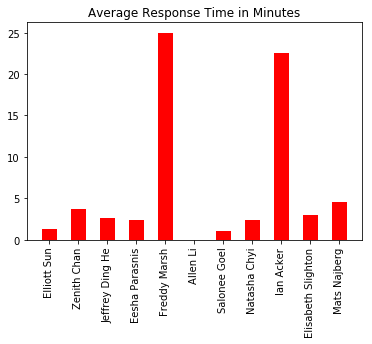

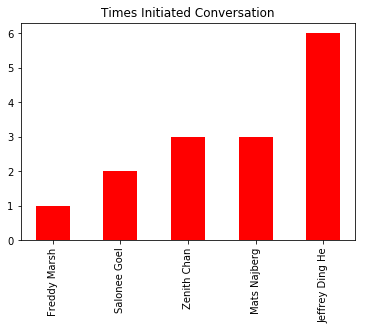

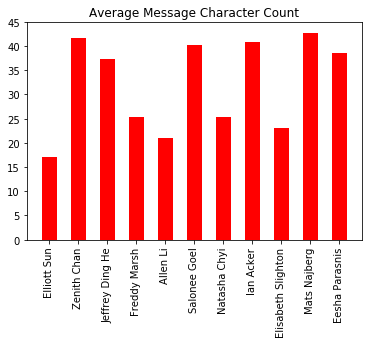

In [84]:
plot(10)